In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
results = pd.read_csv('results.csv')
races=pd.read_csv('races.csv')
imp_df = [constructors, drivers,  results,races]


for df in imp_df:
    df.replace('\\N', np.nan, inplace=True)
    print(df.dtypes)    
    
races.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],inplace=True)

df=pd.merge(results,races[['raceId','year','name','round']],on='raceId',how='left')
df=pd.merge(df,drivers[['driverId','driverRef','nationality']],on='driverId',how='left')
df=pd.merge(df,constructors[['constructorId','constructorRef','name','nationality']],on='constructorId',how='left')
df.drop(columns=['number','position','positionText','laps','fastestLap','statusId','resultId','driverId','constructorId'],axis=1,inplace=True)
df.rename(columns={'rank':'fastest_lap_rank','name_x':'GP_Name','nationality_x':'driver_nationality','name_y':'constructor_name','nationality_y':'constructors_nationality','driverRef':'driver'},inplace=True)



constructorId      int64
constructorRef    object
name              object
nationality       object
url               object
dtype: object
driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object
raceId          int64
year            int64
round           int64
circuitId       int64
name           object
date           object
time           ob

In [11]:
df=df[['year','raceId','GP_Name','round','driver','constructor_name','grid','positionOrder','points','time','milliseconds','fastest_lap_rank','fastestLapTime','fastestLapSpeed','driver_nationality','constructors_nationality']]
df=df.sort_values(by=['year','round','positionOrder'],ascending=[False,True,True])
df.fastestLapSpeed=df.fastestLapSpeed.astype(float)
df.fastest_lap_rank=df.fastest_lap_rank.astype(float)
df.milliseconds=df.milliseconds.astype(float)
print(df.shape)
df.reset_index(drop=True,inplace=True)
print(df.info)

(26759, 16)
<bound method DataFrame.info of        year  raceId             GP_Name  round          driver  \
0      2024    1121  Bahrain Grand Prix      1  max_verstappen   
1      2024    1121  Bahrain Grand Prix      1           perez   
2      2024    1121  Bahrain Grand Prix      1           sainz   
3      2024    1121  Bahrain Grand Prix      1         leclerc   
4      2024    1121  Bahrain Grand Prix      1         russell   
...     ...     ...                 ...    ...             ...   
26754  1950     839  Italian Grand Prix      7          sanesi   
26755  1950     839  Italian Grand Prix      7          manzon   
26756  1950     839  Italian Grand Prix      7            bira   
26757  1950     839  Italian Grand Prix      7         pietsch   
26758  1950     839  Italian Grand Prix      7         bonetto   

      constructor_name  grid  positionOrder  points         time  \
0             Red Bull     1              1    26.0  1:31:44.742   
1             Red Bull     

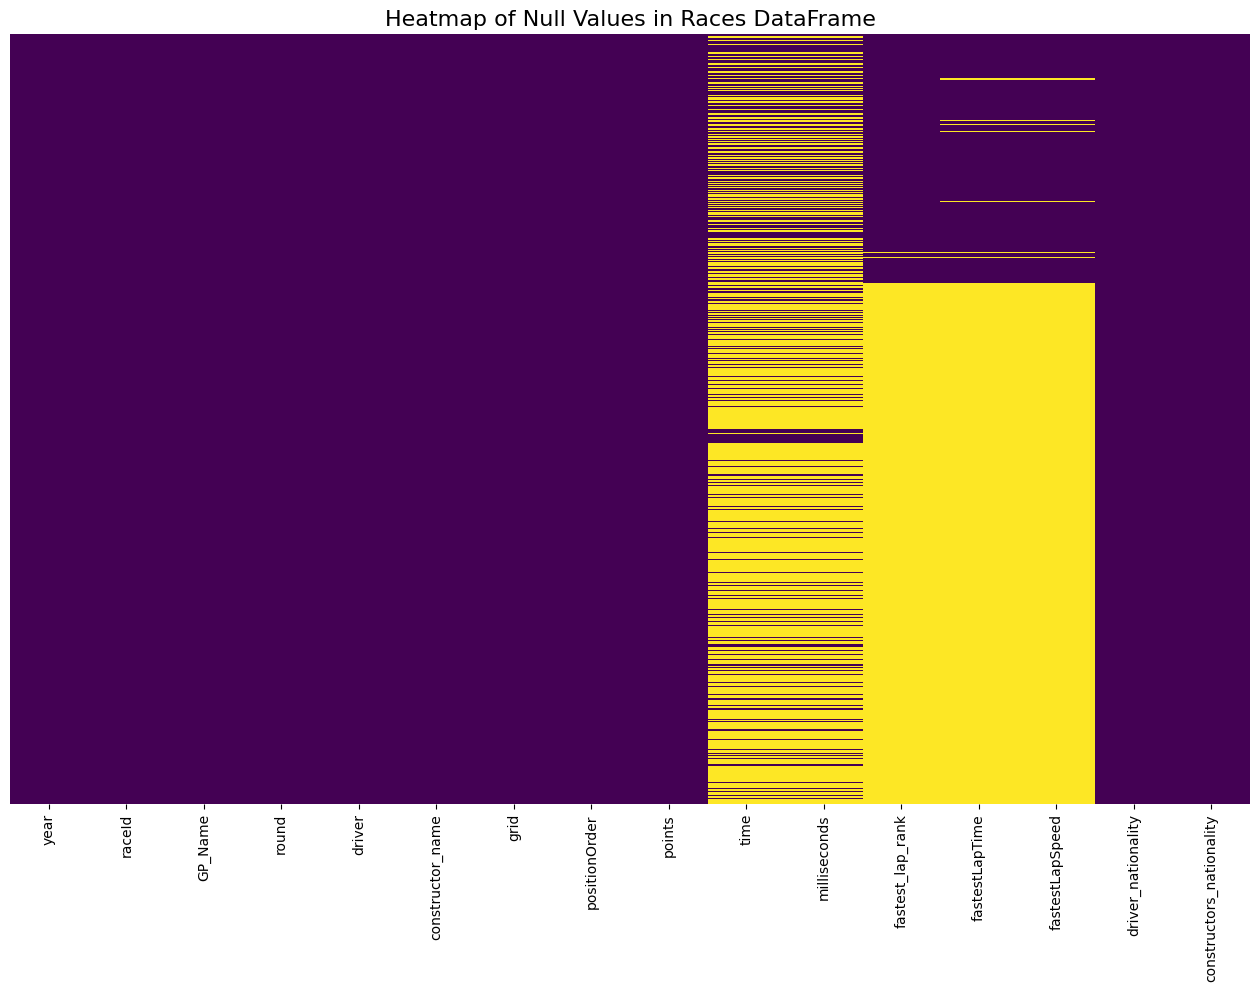

In [12]:
plt.figure(figsize=(16, 10))

# Create a heatmap to visualize null values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add title and display the heatmap
plt.title('Heatmap of Null Values in Races DataFrame', fontsize=16)
plt.show()

In [13]:
print(df.isnull().sum())

year                            0
raceId                          0
GP_Name                         0
round                           0
driver                          0
constructor_name                0
grid                            0
positionOrder                   0
points                          0
time                        19079
milliseconds                19079
fastest_lap_rank            18249
fastestLapTime              18507
fastestLapSpeed             18507
driver_nationality              0
constructors_nationality        0
dtype: int64


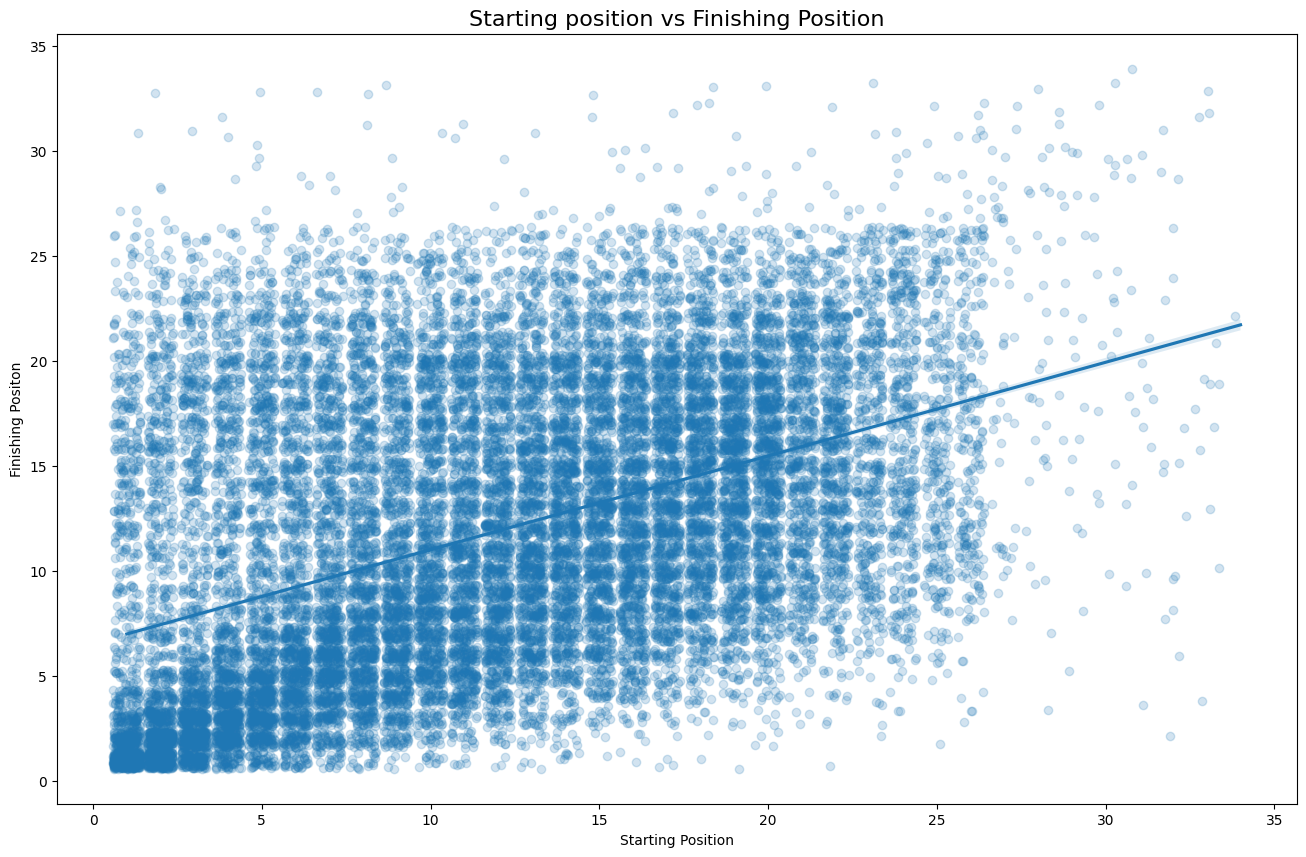

In [14]:
plt.figure(figsize=(16, 10))
df=df[df['grid']!=0]
# Create a heatmap to visualize null values
sns.regplot(df, x='grid',y='positionOrder',x_jitter=0.4,y_jitter=0.4,scatter_kws={'alpha':1/5})


# Add title and display the heatmap
plt.title('Starting position vs Finishing Position', fontsize=16)
plt.xlabel("Starting Position")
plt.ylabel("Finishing Positon")
plt.show()

In [15]:
from scipy.stats import spearmanr

# Spearman Correlation between grid and final position
corr, p_value = spearmanr(df['grid'], df['positionOrder'])
print(f"Spearman Correlation between Grid and Final Position: {corr:.2f} (p-value: {p_value:.4f})")


Spearman Correlation between Grid and Final Position: 0.46 (p-value: 0.0000)


/tmp/ipykernel_145889/3286828155.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=podium_by_grid, x='grid', y='podium', palette='coolwarm')


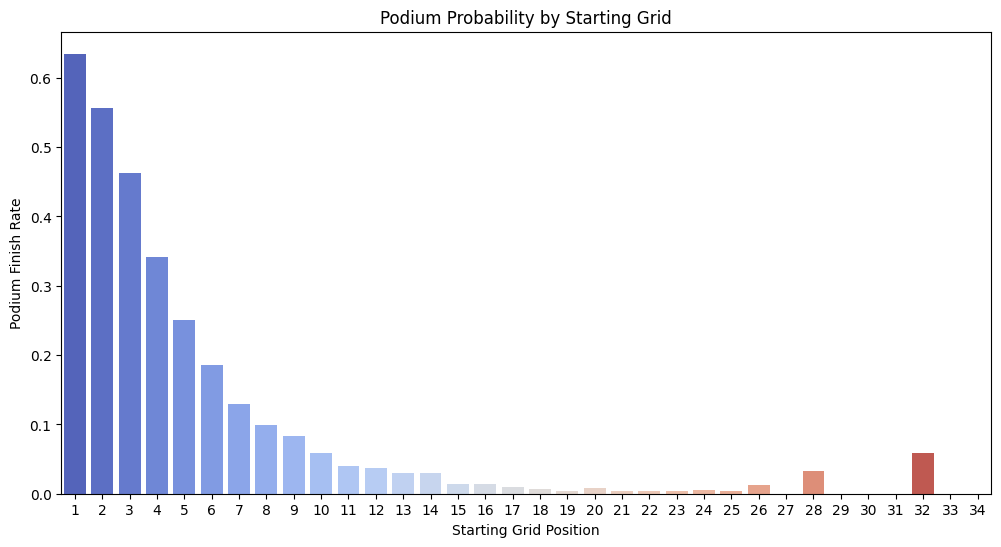

In [16]:
# Podium finishes by grid position
df['podium'] = df['positionOrder'] <= 3
podium_by_grid = df.groupby('grid')['podium'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=podium_by_grid, x='grid', y='podium', palette='coolwarm')
plt.title('Podium Probability by Starting Grid')
plt.xlabel('Starting Grid Position')
plt.ylabel('Podium Finish Rate')
plt.show()


In [17]:
# Calculate Position Change
df['position_change'] = df['grid'] - df['positionOrder']

# Average Position Change per Driver
position_change_stats = df.groupby('driver').agg(
    avg_position_gain=('position_change', 'mean'),
    total_races=('raceId', 'nunique')
).reset_index()

# Set Race Participation Threshold 
race_threshold = 50
position_change_stats = position_change_stats[position_change_stats['total_races'] >= race_threshold]

# Top 10 Drivers Who Gain Most Positions (After Threshold)
top_gainers = position_change_stats.sort_values('avg_position_gain', ascending=False).head(10)

# Display Result
print(f"Top 10 Drivers Who Gain the Most Positions (≥ {race_threshold} Races):")
print(top_gainers[['driver', 'avg_position_gain', 'total_races']])


Top 10 Drivers Who Gain the Most Positions (≥ 50 Races):
        driver  avg_position_gain  total_races
547     palmer           6.142857           84
40      badoer           5.428571           56
705      surer           5.097561           82
701    streiff           4.481481           54
700  stommelen           4.259259           54
159      comas           4.254237           59
129      caffi           3.964912           57
275   ghinzani           3.947368           76
562  pescarolo           3.571429           56
651       salo           2.745455          110


/tmp/ipykernel_145889/1568033185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gainers, x='avg_position_gain', y='driver', palette='viridis')


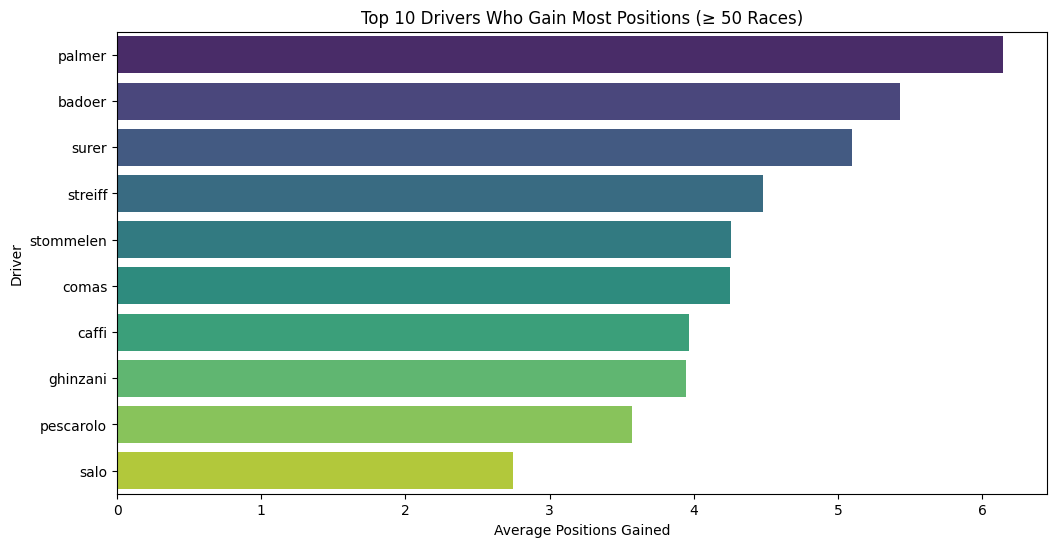

In [18]:


plt.figure(figsize=(12, 6))
sns.barplot(data=top_gainers, x='avg_position_gain', y='driver', palette='viridis')
plt.title(f'Top 10 Drivers Who Gain Most Positions (≥ {race_threshold} Races)')
plt.xlabel('Average Positions Gained')
plt.ylabel('Driver')
plt.show()
